In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import csv

from multiarea_model import MultiAreaModel
from config import base_path, data_path


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# Instantiate 
M = MultiAreaModel({})

Initializing network from dictionary.
RAND_DATA_LABEL 1448


/srv/main-spack-instance-2309/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.23.5-rm3niouf5xjbvqy74ubkcuewixomy5ds/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:Mean of empty slice.
/srv/main-spack-instance-2309/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.23.5-rm3niouf5xjbvqy74ubkcuewixomy5ds/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars




Customized parameters
--------------------
{}


/srv/main-spack-instance-2309/spack/var/spack/environments/ebrains-23-09/.spack-env/view/lib/python3.8/site-packages/dicthash/dicthash.py:47: UserWarning:Float too small for safe conversion tointeger. Rounding down to zero.


In [5]:
# Load experimental functional connectivity
func_conn_data = {}
with open('./figures/Schmidt2018_dyn/Fig8_exp_func_conn.csv', 'r') as f:
    myreader = csv.reader(f, delimiter='\t')
    # Skip first 3 lines
    next(myreader)
    next(myreader)
    next(myreader)
    areas = next(myreader)
    for line in myreader:
        dict_ = {}
        for i in range(len(line)):
            dict_[areas[i]] = float(line[i])
        func_conn_data[areas[myreader.line_num - 5]] = dict_

# Experimental functional connectivity
exp_FC = np.zeros((len(M.area_list),
                   len(M.area_list)))
for i, area1 in enumerate(M.area_list):
    for j, area2 in enumerate(M.area_list):
        exp_FC[i][j] = func_conn_data[area1][area2]

In [6]:
cc_weights_factor_list = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [7]:
# Load a list of simulated functional connectivity
sim_FC = {}
for param in cc_weights_factor_list:
    fn = os.path.join(data_path,
                      'parameter_scan',
                      'functional_connectivity_synaptic_input_{}.npy'.format(param))
    sim_FC[param] = np.load(fn)

In [8]:
def zero_diagonal(matrix):
    """
    Return copy of a matrix with diagonal set to zero.
    """
    M = copy.copy(matrix)
    for i in range(M.shape[0]):
        M[i, i] = 0
    return M

In [9]:
# Compute correlation coefficient
cc_list = []
rsme_list = []
for i, param in enumerate(cc_weights_factor_list):
    # Pearson correlation
    cc = np.corrcoef(zero_diagonal(sim_FC[param]).flatten(),
                     zero_diagonal(exp_FC).flatten())[0][1]
    cc_list.append(cc)
    # RSME
    rsme = np.sqrt(np.mean((sim_FC[param]-exp_FC)**2))
    rsme_list.append(rsme)

# RSME similarity
rsme_sim_list = np.exp(-(rsme_list/np.std(zero_diagonal(exp_FC).flatten())))

# Initialize the list to store tuples of (absolute difference, value, index)
differences = [(abs(0.4 - value), value, cc_weights_factor_list[index]) for index, value in enumerate(cc_list)]

# Sort the list based on the absolute difference
differences.sort()
# print(differences)
print(differences[0])

(0.0015847317063646948, 0.4015847317063647, 7.0)


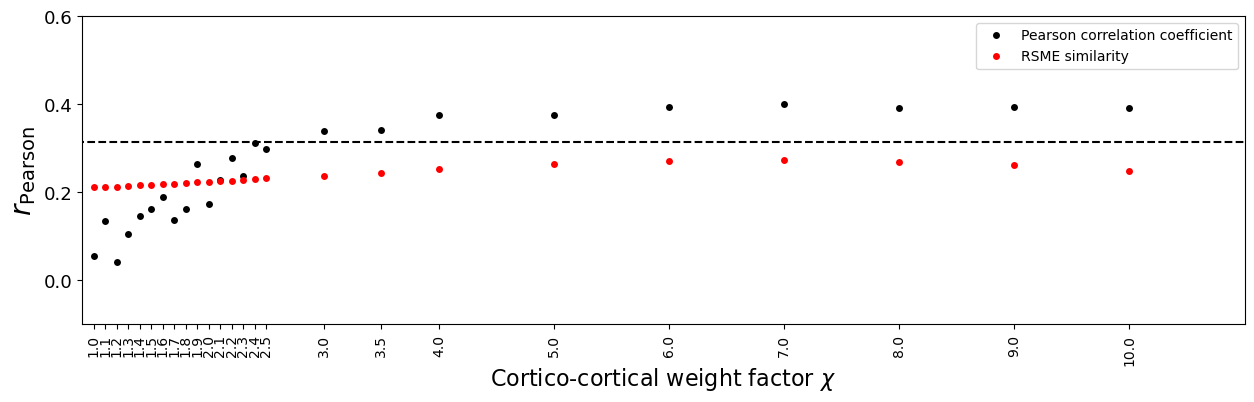

In [10]:
# Plotting
fig = plt.figure(figsize=(15, 4))
ax = plt.subplot()

# Plot the correlation coefficient
ax.plot(cc_weights_factor_list, cc_list, '.', ms=10,
        markeredgecolor='none', label='Pearson correlation coefficient', color='k')

# Plot the RSME similarity
ax.plot(cc_weights_factor_list, rsme_sim_list, '.', ms=10,
        markeredgecolor='none', label='RSME similarity', color='r')

# Correlation between exp. FC and structural connectivity
# Construct the structural connectivity as the matrix of relative
conn_matrix = np.zeros((len(M.area_list), len(M.area_list)))
for i, area1 in enumerate(M.area_list):
    s = np.sum(list(M.K_areas[area1].values()))
    for j, area2 in enumerate(M.area_list):
        value = M.K_areas[area1][area2] / s
        conn_matrix[i][j] = value

# Compute correlation between exp. FC and structural connectivity
cc = np.corrcoef(zero_diagonal(conn_matrix).flatten(),
                 zero_diagonal(exp_FC).flatten())[0][1]

# Formatting
ax.hlines(cc, -0.1, 15, linestyle='dashed', color='k')
ax.set_xlabel(r'Cortico-cortical weight factor $\chi$', labelpad=-0.1, size=16)
ax.set_xlim((0.9, 11.0))
ax.set_ylim((-0.1, 0.6))
ax.set_yticks([0., 0.2, 0.4, 0.6])
ax.set_yticklabels([0., 0.2, 0.4, 0.6], size=13)
ax.set_xticks(cc_weights_factor_list)
ax.set_xticklabels(cc_weights_factor_list, size=10, rotation=90)

plt.legend()

plt.show()